In [1]:
# Import some python libraries
import rasterio
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import json
import os

# Setup a dask cluster
import dask
from dask.distributed import Client
from dask_kubernetes import KubeCluster

# Settings to display all outputs within notebook
%matplotlib inline
%load_ext wurlitzer

In [2]:
# Debug logging
#import logging
#logger = logging.getLogger()
#logger.setLevel(logging.DEBUG)

In [3]:
# Print package versions

print('Dask version: ', dask.__version__)
print('Xarray version: ', xr.__version__)
print('Rasterio version: ', rasterio.__version__)

Dask version:  0.19.4
Xarray version:  0.10.9
Rasterio version:  1.0.8


In [4]:
# Launch Dask Cluster
cluster = KubeCluster(n_workers=5)
cluster

In [5]:
client = Client(cluster)
client

Client Scheduler: tcp://10.49.82.14:45852 Dashboard: /user/scottyhq-cog-benchmarking-k9b3okda/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Read single Cloud-Optimized Geotiff

In [6]:
# !aws s3api get-bucket-location --bucket cog-benchmark-landsat
#us-west-2
# !aws s3 ls s3://cog-benchmark-landsat
#2018-08-27 12:55:19   56368448 aws-LC08_L1TP_047027_20180113_20180119_01_T1_B4.TIF
#2018-08-27 12:55:19   88498262 aws-cog.TIF
#2018-08-27 12:55:19   65195094 google-LC08_L1TP_047027_20180113_20180119_01_T1_B4.TIF
#2018-08-27 12:55:19  118157830 google-cog.TIF
#2018-08-27 12:55:19  125384178 usgs-LC08_L1TP_047027_20180113_20180119_01_T1_B4.TIF

In [7]:
# NOTE temporary public bucket
bucket = 'cog-benchmark-landsat'
cog = 'aws-cog.TIF'
region = 'us-west-2'
s3URL = f's3://{bucket}/{cog}'
httpURL = f'https://s3-{region}.amazonaws.com/{bucket}/{cog}'
print(httpURL)

https://s3-us-west-2.amazonaws.com/cog-benchmark-landsat/aws-cog.TIF


In [8]:
# Validate that the file is actually a COG
query = f'http://cog-validate.radiant.earth/api/validate?url={httpURL}'
response = !curl -s {query}
json.loads(response[0])

{'status': 'success',
 'gdal_info': {'files': ['/vsicurl/https://s3-us-west-2.amazonaws.com/cog-benchmark-landsat/aws-cog.TIF'],
  'cornerCoordinates': {'upperRight': [588915.0, 5374215.0],
   'lowerLeft': [353085.0, 5135085.0],
   'lowerRight': [588915.0, 5135085.0],
   'upperLeft': [353085.0, 5374215.0],
   'center': [471000.0, 5254650.0]},
  'wgs84Extent': {'type': 'Polygon',
   'coordinates': [[[-124.9889812, 48.5038603],
     [-124.9095439, 46.3533935],
     [-121.8441107, 46.3634975],
     [-121.7960015, 48.5147498],
     [-124.9889812, 48.5038603]]]},
  'description': 'https://s3-us-west-2.amazonaws.com/cog-benchmark-landsat/aws-cog.TIF',
  'driverShortName': 'GTiff',
  'driverLongName': 'GeoTIFF',
  'bands': [{'mask': {'overviews': [{'size': [3931, 3986]},
      {'size': [1966, 1993]},
      {'size': [983, 997]},
      {'size': [492, 499]},
      {'size': [246, 250]},
      {'size': [123, 125]}],
     'flags': ['PER_DATASET']},
    'band': 1,
    'colorInterpretation': 'Gray',


In [9]:
% time

# NOTE: Red text output is coming from gdal behind the scenes (info on HTTP requests)
# this is coming from the wurlitzer package (%load_ext wurlitzer)

# Warning, timing calls are misleading if code has recently been run 
# b/c results are cached...

# Read individual COG metadata with rasterio
with rasterio.Env(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
                  CURL_CA_BUNDLE='/etc/ssl/certs/ca-certificates.crt', #For Ubunutu
                  CPL_VSIL_CURL_ALLOWED_EXTENSIONS='TIF',
                  CPL_DEBUG=True,
                  CPL_CURL_VERBOSE=True,
                  VSI_CACHE=True,
                  region_name=region):
    with rasterio.open(httpURL, 'r') as src:
        print(src.profile)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs


* Couldn't find host s3-us-west-2.amazonaws.com in the .netrc file; using defaults
*   Trying 52.218.208.80...
* TCP_NODELAY set
* Connected to s3-us-west-2.amazonaws.com (52.218.208.80) port 443 (#0)
* ALPN, offering http/1.1
* Cipher selection: ALL:!EXPORT:!EXPORT40:!EXPORT56:!aNULL:!LOW:!RC4:@STRENGTH
* successfully set certificate verify locations:
*   CAfile: /etc/ssl/certs/ca-certificates.crt
  CApath: none
* SSL connection using TLSv1.2 / ECDHE-RSA-AES128-SHA
* ALPN, server did not agree to a protocol
* Server certificate:
*  subject: C=US; ST=Washington; L=Seattle; O=Amazon.com Inc.; CN=*.s3-us-west-2.amazonaws.com
*  start date: Aug  2 00:00:00 2018 GMT
*  expire date: Nov  6 12:00:00 2019 GMT
*  subjectAltName: host "s3-us-west-2.amazonaws.com" matched cert's "s3-us-west-2.amazonaws.com"
*  issuer: C=US; O=DigiCert Inc; OU=www.digicert.com; CN=DigiCert Baltimore CA-2 G2
*  SSL certificate verify ok.
> HEAD /cog-benchmark-landsat/aws-cog.TIF HTTP/1.1
Host: s3-us-west-2.amazona

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7861, 'height': 7971, 'count': 1, 'crs': CRS({'init': 'epsg:32610'}), 'transform': Affine(30.0, 0.0, 353085.0,
       0.0, -30.0, 5374215.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


< HTTP/1.1 206 Partial Content
< x-amz-id-2: 46aaSbhmr60Cw6SwD7xXd0M3uk2mnoAUSxcgw3pXVeuGgbZReHMWlg8iDqLn+Zj5a9n51EBL9kM=
< x-amz-request-id: 1DB365EF058BF79B
< Date: Fri, 26 Oct 2018 01:01:10 GMT
< Last-Modified: Mon, 27 Aug 2018 19:55:19 GMT
< ETag: "cda5406fe37489657e98b3f2c8bf458b-11"
< Accept-Ranges: bytes
< Content-Range: bytes 0-49151/88498262
< Content-Type: image/tiff
< Content-Length: 49152
< Server: AmazonS3
< 
* Connection #0 to host s3-us-west-2.amazonaws.com left intact


In [10]:
% time
# Read first 5 tiles:
ntiles = 5

with rasterio.Env(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
                  CURL_CA_BUNDLE='/etc/ssl/certs/ca-certificates.crt', #For Ubunutu
                  CPL_VSIL_CURL_ALLOWED_EXTENSIONS='TIF',
                  CPL_CURL_VERBOSE=True,
                  VSI_CACHE=True,
                  region_name=region):
    with rasterio.open(httpURL, 'r') as src:
        # Window(col_off=0.0, row_off=0.0, width=100.0, height=100.0)
        width = src.profile['blockxsize'] * ntiles
        height = src.profile['blockysize']
        window = rasterio.windows.Window(0, 0, width, height)
        w = src.read(1, window=window)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.68 µs


* Couldn't find host s3-us-west-2.amazonaws.com in the .netrc file; using defaults
* Found bundle for host s3-us-west-2.amazonaws.com: 0x36a79c0 [can pipeline]
* Re-using existing connection! (#0) with host s3-us-west-2.amazonaws.com
* Connected to s3-us-west-2.amazonaws.com (52.218.208.80) port 443 (#0)
> GET /cog-benchmark-landsat/aws-cog.TIF HTTP/1.1
Host: s3-us-west-2.amazonaws.com
Accept: */*
Range: bytes=23021669-23636396

< HTTP/1.1 206 Partial Content
< x-amz-id-2: DQEjh83OjGn4kt17SviJwE/cwzTU5MGD9WnYYMF2e6dIPvnNuuq28cA7njqv4DUMyDDzLDo1yQk=
< x-amz-request-id: F8AE67B1142EE3A2
< Date: Fri, 26 Oct 2018 01:01:13 GMT
< Last-Modified: Mon, 27 Aug 2018 19:55:19 GMT
< ETag: "cda5406fe37489657e98b3f2c8bf458b-11"
< Accept-Ranges: bytes
< Content-Range: bytes 23021669-23636396/88498262
< Content-Type: image/tiff
< Content-Length: 614728
< Server: AmazonS3
< 
* Connection #0 to host s3-us-west-2.amazonaws.com left intact


In [11]:
# Compare to loading with xarray
w

array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ..., 9242, 9119, 9235],
       [   0,    0,    0, ..., 9150, 9402, 9485],
       [   0,    0,    0, ..., 9108, 9328, 9491]], dtype=uint16)

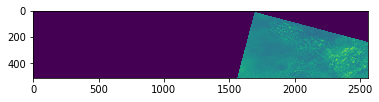

In [12]:
plt.imshow(w)

In [13]:
# Note that the blocksize of the image is 256 by 256, so we want xarray to use some multiple of that
xchunk = 512
ychunk = 512

# How to get open_rasterio() to use rasterio.Env manager?
# No verbose output from the following:

# https://rasterio.readthedocs.io/en/latest/topics/configuration.html

with rasterio.Env(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
                  CURL_CA_BUNDLE='/etc/ssl/certs/ca-certificates.crt', #For Ubunutu
                  CPL_VSIL_CURL_ALLOWED_EXTENSIONS='TIF',
                  CPL_CURL_VERBOSE=True,
                  VSI_CACHE=True,
                  region_name=region):
    with xr.open_rasterio(httpURL, chunks={'band': 1, 'x': xchunk, 'y': ychunk}) as da:
        print(da)

<xarray.DataArray (band: 1, y: 7971, x: 7861)>
dask.array<shape=(1, 7971, 7861), dtype=uint16, chunksize=(1, 512, 512)>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 5.374e+06 5.374e+06 5.374e+06 ... 5.135e+06 5.135e+06
  * x        (x) float64 3.531e+05 3.531e+05 3.532e+05 ... 5.889e+05 5.889e+05
Attributes:
    transform:   (30.0, 0.0, 353085.0, 0.0, -30.0, 5374215.0)
    crs:         +init=epsg:32610
    res:         (30.0, 30.0)
    is_tiled:    1
    nodatavals:  (nan,)


In [17]:
# Instead set os environment variables
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='YES'
os.environ['CURL_CA_BUNDLE']='/etc/ssl/certs/ca-certificates.crt'
os.environ['CPL_VSIL_CURL_ALLOWED_EXTENSIONS']='TIF'
os.environ['CPL_CURL_VERBOSE']='YES'
os.environ['VSI_CACHE']='TRUE'
os.environ['AWS_REGION']='us-west-2'

In [18]:
%time

# Read same subset via xarray + dask

da = xr.open_rasterio(httpURL,
                      chunks={'band': 1, 
                              'x': xchunk, 
                              'y': ychunk})

data = da.isel(x=slice(0,width), y=slice(0,height))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs


RasterioIOError: '/vsicurl/https://s3-us-west-2.amazonaws.com/cog-benchmark-landsat/aws-cog.TIF' does not exist in the file system, and is not recognized as a supported dataset name.

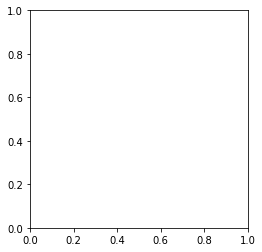

In [19]:
%time 

plt.imshow(data)

In [21]:
!gdalinfo '/vsicurl/https://s3-us-west-2.amazonaws.com/cog-benchmark-landsat/aws-cog.TIF'

gdalinfo: symbol lookup error: /srv/conda/bin/../lib/libgdal.so.20: undefined symbol: _ZN11xercesc_3_211InputSource11setEncodingEPKDs


In [23]:
# Look at open_rasterio() function
#xr.open_rasterio??

Signature: xr.open_rasterio(filename, parse_coordinates=None, chunks=None, cache=None, lock=None)
Source:   
def open_rasterio(filename, parse_coordinates=None, chunks=None, cache=None,
                  lock=None):
    """Open a file with rasterio (experimental).

    This should work with any file that rasterio can open (most often:
    geoTIFF). The x and y coordinates are generated automatically from the
    file's geoinformation, shifted to the center of each pixel (see
    `"PixelIsArea" Raster Space
    <http://web.archive.org/web/20160326194152/http://remotesensing.org/geotiff/spec/geotiff2.5.html#2.5.2>`_
    for more information).

    You can generate 2D coordinates from the file's attributes with::

        from affine import Affine
        da = xr.open_rasterio('path_to_file.tif')
        transform = Affine(*da.attrs['transform'])
        nx, ny = da.sizes['x'], da.sizes['y']
        x, y = np.meshgrid(np.arange(nx)+0.5, np.arange(ny)+0.5) * transform


    Parameters
    